In [2]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Load the unseen data
clv_unseen = pd.read_csv('unseen_auto_insurance.csv')

In [3]:
# Split the unseen data into two halves (50% each), stratified by the 'Response'
clv_unseen_untreated, clv_unseen_treated = train_test_split(
    clv_unseen,
    stratify=clv_unseen['Response'],
    test_size=0.5,
    random_state=42
)

### Dataset Overview:
- The dataset is divided to separate the data for testing purposes.
- This division **splits the data evenly into a 50:50 ratio** and **uses stratification to split the 'Response' column evenly**.
- Testing will **use the entire dataset that has been split evenly (913 data points)** for each case, to ensure that the initial testing conditions are **equal for both cases**.

# Section 1: Minimal Treatment (One-Hot Encoding)

In [4]:
# Dropping unnecessary columns
clv_unseen_untreated = clv_unseen_untreated.drop(columns=['Customer', 'Effective To Date', 'Unnamed: 0'])

# Mapping 'Yes'/'No' to 1/0 in the Response column
clv_unseen_untreated['Response'] = clv_unseen_untreated['Response'].map({'Yes': 1, 'No': 0}).astype(float)

# Split the data into features and target variable
X_unseen_untreated = clv_unseen_untreated.drop('Response', axis=1)
y_unseen_untreated = clv_unseen_untreated['Response']

# Identify categorical columns automatically
categorical_columns = X_unseen_untreated.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical columns automatically
numerical_columns = X_unseen_untreated.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Apply One-Hot Encoding to all categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
X_unseen_untreated_categorical = one_hot_encoder.fit_transform(X_unseen_untreated[categorical_columns])

# Convert One-Hot Encoded data to DataFrame with appropriate column names
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(categorical_columns)
X_unseen_untreated_categorical = pd.DataFrame(X_unseen_untreated_categorical, columns=one_hot_encoded_columns, index=X_unseen_untreated.index)

# Combine the numerical features with the one-hot encoded categorical features
X_unseen_combined = pd.concat([X_unseen_untreated[numerical_columns], X_unseen_untreated_categorical], axis=1)

### Section 1:
- In this section, the data will **receive minimal treatment to be readable by the KNN model**, which only accepts numerical data.
- To make the data numerical and ensure the number of columns meets the model's requirement of 63 columns, we perform **Encoding** on all categorical columns using **One-Hot Encoder**.
- We **Drop** data that is not used in the model, specifically **'Customer', 'Effective To Date', and 'Unnamed: 0'**.

In [5]:
# Load the knn_tuned model
knn_tuned_model = joblib.load('knn_tuned_model.pkl')

In [6]:
# Predict using the untreated data model
y_pred_untreated = knn_tuned_model.predict(X_unseen_combined)

y_proba_untreated = knn_tuned_model.predict_proba(X_unseen_combined)

In [7]:
# Evaluate performance
print("Performance on Minimally Treated Data (One-Hot Encoding):")
print("Accuracy:", accuracy_score(y_unseen_untreated, y_pred_untreated))
print("Classification Report:\n", classification_report(y_unseen_untreated, y_pred_untreated))
print("Confusion Matrix:\n", confusion_matrix(y_unseen_untreated, y_pred_untreated))

Performance on Minimally Treated Data (One-Hot Encoding):
Accuracy: 0.6111719605695509
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.56      0.71       782
         1.0       0.26      0.91      0.40       131

    accuracy                           0.61       913
   macro avg       0.62      0.73      0.56       913
weighted avg       0.87      0.61      0.67       913

Confusion Matrix:
 [[439 343]
 [ 12 119]]


## Untreated data Analysis

In [8]:
# Count total 'Yes' and 'No' predictions
untreated_yes_count = sum(y_pred_untreated == 1)

# Count total 'Yes' and 'No' predictions
untreated_correct_yes = sum((y_pred_untreated == 1) & (y_unseen_untreated == 1))

# Calculate accuracy for 'Yes' and 'No' separately
untreated_yes_accuracy = untreated_correct_yes / untreated_yes_count if untreated_yes_count > 0 else 0

# Print results for untreated data
print(f"Untreated Data - 'Yes' Predictions: {untreated_yes_count}, Correctly Predicted 'Yes': {untreated_correct_yes}")
print(f"Untreated Data - 'Yes' Accuracy: {untreated_yes_accuracy*100:.2f}%")

Untreated Data - 'Yes' Predictions: 462, Correctly Predicted 'Yes': 119
Untreated Data - 'Yes' Accuracy: 25.76%


### Analysis:
The results from the test on untreated data show the following output:
- The number of **'Yes' Predictions** is 462, but out of these, only **119 were correctly predicted as 'Yes'**. This means that the model can only correctly predict **25.76% of the 'Yes' responses**.

# Section 2: Preparing and testing treated data with pipe_tuned_pipeline

In [9]:
# Dropping unnecessary columns
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer', 'Effective To Date', 'Unnamed: 0'])

# Mapping 'Yes'/'No' to 1/0 in the Response column
clv_unseen_treated['Response'] = clv_unseen_treated['Response'].map({'Yes': 1, 'No': 0}).astype(float)

# Applying logarithmic transformation
clv_unseen_treated['CLV_log'] = np.log1p(clv_unseen_treated['Customer Lifetime Value'])
clv_unseen_treated['Income_Log'] = np.log1p(clv_unseen_treated['Income'])
clv_unseen_treated['TCA_Log'] = np.log1p(clv_unseen_treated['Total Claim Amount'])

# Dropping the original columns after logging
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer Lifetime Value', 'Income', 'Total Claim Amount'])

# Splitting treated data into features and target variable
X_unseen_treated = clv_unseen_treated.drop(columns=['Response'])
y_unseen_treated = clv_unseen_treated['Response']



### Section 2:
- In this section, the data will **receive maximum treatment for the main model's needs**, so the data becomes numerical, and the number of columns **matches the model's requirement** of 52 columns.
- We apply encoding to all categorical columns in the pipeline using **One-Hot Encoder, Binary Encoder, and Ordinal Encoder**, depending on the type of data in each column.
- We also apply a **Natural Logarithm** to reduce large numeric values in the dataset.
- We **Drop** columns that will not be used in the model and duplicate columns, such as **'Customer Lifetime Value', 'Income', 'Total Claim Amount', 'Customer', 'Effective To Date', and 'Unnamed: 0'**.

In [10]:
# Load the pipe_tuned pipeline
pipe_tuned_pipeline = joblib.load('pipe_tuned_pipeline.pkl')

In [11]:
# Predict using the treated data pipeline
y_pred_treated = pipe_tuned_pipeline.predict(X_unseen_treated)

y_proba_treated = pipe_tuned_pipeline.predict_proba(X_unseen_treated)

In [12]:
# Evaluate performance
print("\nPerformance on Treated Data (pipe_tuned_pipeline):")
print("Accuracy:", accuracy_score(y_unseen_treated, y_pred_treated))
print("Classification Report:\n", classification_report(y_unseen_treated, y_pred_treated))
print("Confusion Matrix:\n", confusion_matrix(y_unseen_treated, y_pred_treated))


Performance on Treated Data (pipe_tuned_pipeline):
Accuracy: 0.8982494529540481
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94       783
         1.0       0.59      0.98      0.73       131

    accuracy                           0.90       914
   macro avg       0.79      0.93      0.84       914
weighted avg       0.94      0.90      0.91       914

Confusion Matrix:
 [[693  90]
 [  3 128]]


## Treated data Analysis

In [13]:
# Count total 'Yes' and 'No' predictions
treated_yes_count = sum(y_pred_treated == 1)

# Count correct 'Yes' and 'No' predictions
treated_correct_yes = sum((y_pred_treated == 1) & (y_unseen_treated == 1))

# Calculate accuracy for 'Yes' and 'No'
treated_yes_accuracy = treated_correct_yes / treated_yes_count if treated_yes_count > 0 else 0

# Print results for treated data
print(f"Treated Data - 'Yes' Predictions: {treated_yes_count}, Correctly Predicted 'Yes': {treated_correct_yes}")
print(f"Treated Data - 'Yes' Accuracy: {treated_yes_accuracy*100:.2f}%")

Treated Data - 'Yes' Predictions: 218, Correctly Predicted 'Yes': 128
Treated Data - 'Yes' Accuracy: 58.72%


### Analysis:
The results from the test on untreated data show the following output:
- The number of **'Yes' Predictions** is 218, and out of these, **128 were correctly predicted as 'Yes'**. This means that the model can correctly predict **58.72% of the 'Yes' responses**.

# Model Amplification Analysis

In [14]:
# Calculate gaps for untreated data
gap_yes_untreated = untreated_yes_count - untreated_correct_yes  # Total 'Yes' predictions (462) - Correct 'Yes' predictions (119)

# Calculate gaps for treated data
gap_yes_treated = treated_yes_count - treated_correct_yes    # Total 'Yes' predictions (218) - Correct 'Yes' predictions (128)

# Print the results
print(f"Untreated Data - 'Yes' Gap: {gap_yes_untreated}")

Untreated Data - 'Yes' Gap: 343


In [15]:
# Calculate multiplier gap for 'Yes' predictions
multiplier_gap_yes = gap_yes_untreated / gap_yes_treated if gap_yes_treated != 0 else float('inf')

# Print the results
print(f"Multiplier Gap - 'Yes': {multiplier_gap_yes:.2f} times better")

Multiplier Gap - 'Yes': 3.81 times better


In [16]:
# Total counts of all gaps
total_gaps_yes = gap_yes_untreated + gap_yes_treated

# Proportional percentages for gaps
proportional_gap_yes_untreated = (gap_yes_untreated / total_gaps_yes) * 100
proportional_gap_yes_treated = (gap_yes_treated / total_gaps_yes) * 100

print(f"Proportional Gap - Untreated 'Yes': {proportional_gap_yes_untreated:.2f}%, Treated 'Yes': {proportional_gap_yes_treated:.2f}%")

Proportional Gap - Untreated 'Yes': 79.21%, Treated 'Yes': 20.79%


In [17]:
improvement_yes = proportional_gap_yes_untreated - proportional_gap_yes_treated

print(f"Improvement in 'Yes' Predictions: {improvement_yes:.2f}%")

Improvement in 'Yes' Predictions: 58.43%


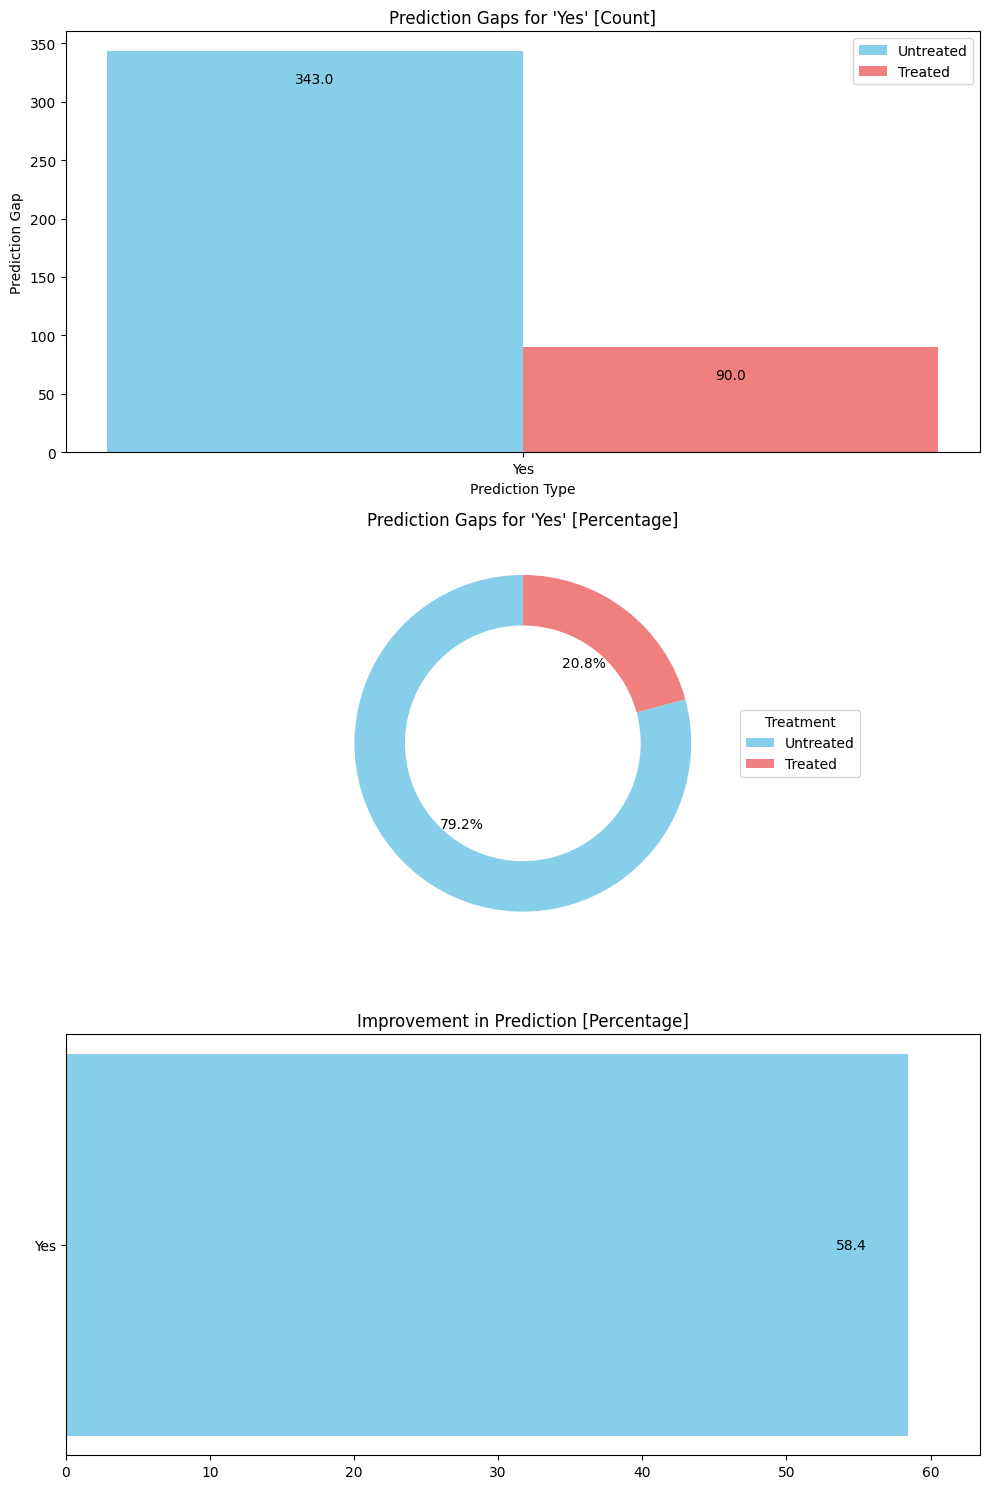

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for visualization (Replace these with your actual values)
categories = ['Untreated', 'Treated']
untreated_gaps = [gap_yes_untreated]  # Only Yes data for untreated gaps
treated_gaps = [gap_yes_treated]      # Only Yes data for treated gaps

# Define the width for the bars in individual plots
width = 0.35

# Setup figure with GridSpec for custom layout
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])  # Adjusted to 3x1 grid

# Bar plot for "Yes" data
ax1 = fig.add_subplot(gs[0, 0])
x_yes = np.arange(1)
bars1_yes = ax1.bar(x_yes - width/2, untreated_gaps, width, label='Untreated', color='skyblue')
bars2_yes = ax1.bar(x_yes + width/2, treated_gaps, width, label='Treated', color='lightcoral')
ax1.set_xlabel('Prediction Type')
ax1.set_ylabel('Prediction Gap')
ax1.set_title("Prediction Gaps for 'Yes' [Count]")
ax1.set_xticks(x_yes)
ax1.set_xticklabels(['Yes'])
ax1.legend()

# Display values on bars for "Yes" plot
for bar in bars1_yes + bars2_yes:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval - 30, f'{yval:.1f}', ha='center', va='bottom')

# Donut chart for "Yes" predictions gaps
ax3 = fig.add_subplot(gs[1, 0])
wedges1 = ax3.pie([gap_yes_untreated, gap_yes_treated], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'],
                  wedgeprops={'width': 0.3})[0]
ax3.set_title("Prediction Gaps for 'Yes' [Percentage]")
ax3.legend(wedges1, categories, title="Treatment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Horizontal bar chart for improvements, spanning the entire bottom row
ax5 = fig.add_subplot(gs[2, 0])
bars_improvement = ax5.barh(['Yes'], [improvement_yes], color='skyblue')
ax5.set_title('Improvement in Prediction [Percentage]')
ax5.set_xlim(0, improvement_yes + 5)  # Extend x-limit for better visibility

# Display value on horizontal bar
width = improvement_yes
yval = 0  # Single bar, so use 0 for "Yes" bar
ax5.text(width - 5, yval, f'{width:.1f}', ha='left', va='center')

# Adjust layout to ensure everything fits nicely
plt.tight_layout()
plt.show()

## Model Amplification Summary

### Prediction Gap:
In this data, there is a **significant prediction gap** in the results:

- The **Untreated Data** has a gap **between total predictions and correct predictions** of **343 data points**.
- In contrast, the **Treated Data** has a gap **between total predictions and correct predictions** of **90 data points**.
- Comparing both, the **Untreated Data** has a gap of **79.2%**, while the **Treated Data** has a much lower gap of **20.8%**.
- There is an increase in accuracy due to the reduced gap.

### Analysis Conclusion:
The prediction gap shows the difference between the number of predictions made and the number of correct predictions. A smaller gap means the model is more accurate.

<br>For the Untreated Data, the gap is large (343 data points), meaning the model often predicts wrong because the data isn't well-prepared. The accuracy here is only 79.2%. For the Treated Data, the gap is much smaller (90 data points), meaning the model makes more correct predictions. The treated data has been processed and prepared to work better with the model, leading to higher accuracy at 20.8%. This shows that when data is properly prepared (treated), the model can predict more accurately because the data fits the model's needs better, reducing mistakes.